<a href="https://colab.research.google.com/github/prog815/abscur_prediction/blob/master/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D1%83%D0%B5%D0%BC_%D0%BD%D0%B0_%D0%BB%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%BE%D0%B9_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_(linear_model_RidgeCV)_%D0%BE%D1%82%D0%BD%D0%BE%D1%81%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%B8%D0%B7%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F_%D0%B0%D0%B1%D1%81%D0%BE%D0%BB%D1%8E%D1%82%D0%BD%D1%8B%D1%85_%D0%B2%D0%B0%D0%BB%D1%8E%D1%82%D0%BD%D1%8B%D1%85_%D0%BA%D1%83%D1%80%D1%81%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Прогнозируем на линейной модели (linear_model.RidgeCV) относительные изменения абсолютных валютных курсов**

**Абсолютный курс**

Енин А.В.

г. Оренбург

2020 г.

Сайт - http://www.abscur.ru

Twitter - https://twitter.com/abscurs

ВКонтакте -  https://vk.com/abscur

Одноклассники -  https://ok.ru/group/53547043520717

FB -  https://www.facebook.com/abscur 

Telegram - https://t.me/AbsCur

GitHub - https://github.com/prog815/abscur_prediction

Прогнозируем следующие значения относительных изменений абсолютного курса. Для этого применяем линейную модель (linear_model.RidgeCV с поиском оптимальных) по предыдущим значениям (с некоторым окном) относительных изменений абсолютного курса.

# Библиотеки

In [0]:
import datetime
print(datetime.date.today())

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

2020-03-29


# Импорт данных

Таблица с историей абсолютных курсов: https://docs.google.com/spreadsheets/d/1_-cdNCIC6NgyRDj0zLJBaohXo-K8qCfxfDLbYq2JLhs/edit#gid=422799220

In [0]:
data_url = 'https://docs.google.com/spreadsheets/d/1_-cdNCIC6NgyRDj0zLJBaohXo-K8qCfxfDLbYq2JLhs/export?format=csv&id=1_-cdNCIC6NgyRDj0zLJBaohXo-K8qCfxfDLbYq2JLhs&gid=422799220'
abs_data = pd.read_csv(data_url,decimal=',',parse_dates=True,index_col=0)
abs_data.shape

(1303, 45)

# Подготовка данных

Вычисляем матрицу относительных изменений абсолютных валютных курсов

In [0]:
dates = abs_data.index.values # даты
cur_names = abs_data.columns.values # имена валют
data = abs_data.values # матрица абсолютных курсов
d_data = np.zeros_like(data) # матрица относительных изменений
d_data[1:,:] = (data[1:,:]-data[:-1,:])/data[:-1,:] # расчет матрицы относительных изменений

# Готовоим входы и выходы модели

Нормируем относительные изменения.
Сибираем матрицу входов и выходов для модели прогнозирования.

In [0]:
window = 30 # окно для входов

y = d_data.copy()

y = (y - y.mean(axis=0)) / y.std(axis=0) # нормаируем

x_ = [0]*window

for w in range(window):
    x_[w] = np.zeros_like(y)
    x_[w][(1+w):,:] = y[:(-1-w),:]

X = np.concatenate(x_,axis=1)[window:,:]
y = y[window:]

In [0]:
X.shape,y.shape

((1273, 1350), (1273, 45))

# Учим модель

Используем стандартный пакет **scikit-learn**

https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification

Готовим обучающую и тестовую выборки. Не перемешиваем. Выборки последовательные.
Но при перемешивании получили те-же результаты.

Создаем модель.
Учим модель на обучающей выборке.

Прогнозируем результаты для тестовой и обучающей выборок.


In [0]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False)

reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 100),normalize=True)

reg.fit(X_train,y_train)

print('best alpha',reg.alpha_)

preds_train = reg.predict(X_train)
preds_test = reg.predict(X_test)

best alpha 75.64633275546291


лучший альфа

# Смотрим результаты на графиках



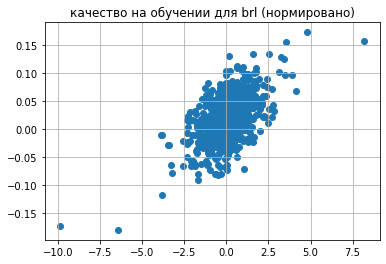

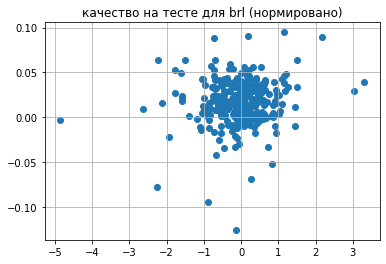

In [0]:
n = np.random.randint(y.shape[1])

plt.figure()
plt.scatter(y_train[:,n],preds_train[:,n])
plt.grid()
plt.title("качество на обучении для {} (нормировано)".format(cur_names[n]))
plt.show()

plt.figure()
plt.scatter(y_test[:,n],preds_test[:,n])
plt.grid()
plt.title("качество на тесте для {} (нормировано)".format(cur_names[n]))
plt.show()

сильно сжалось по оси Y 
предсказания на порядок ниже чем оргинал

# Метрики

In [0]:
from sklearn.metrics import *

смотрим разные метрики
даже свою метрику по корреляции смотрим

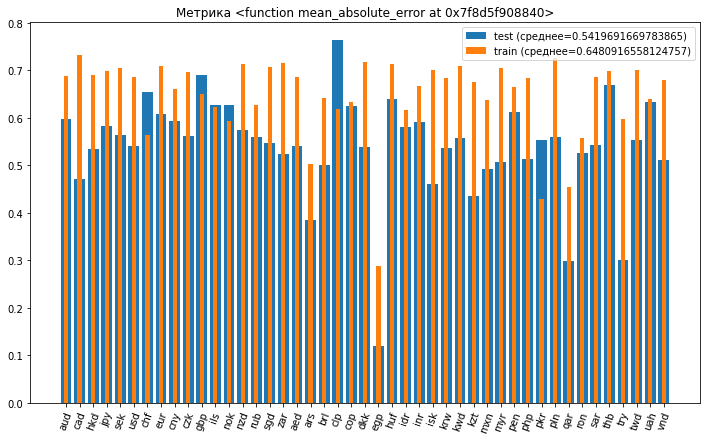

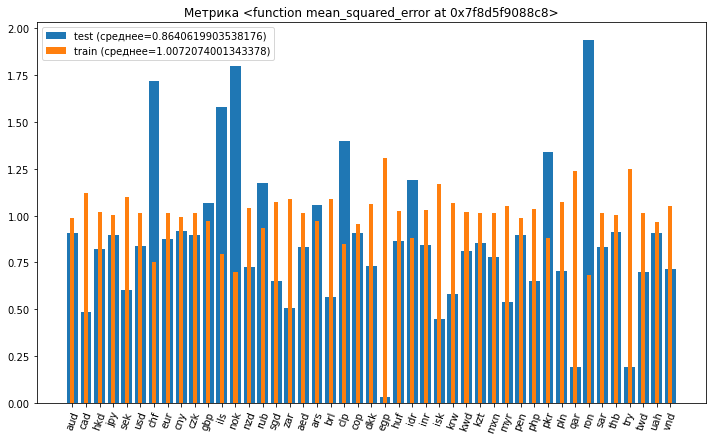

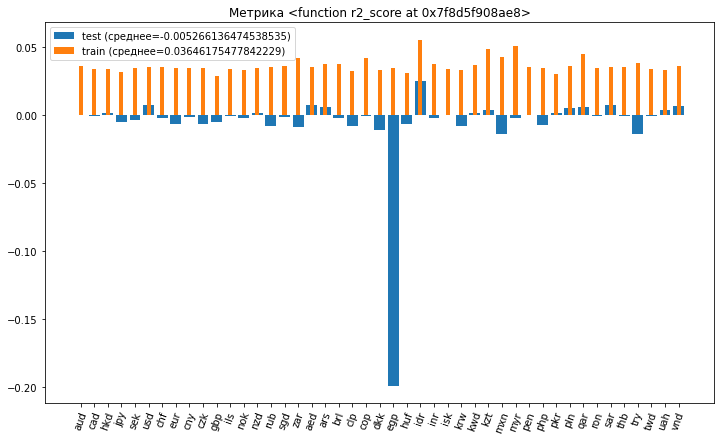

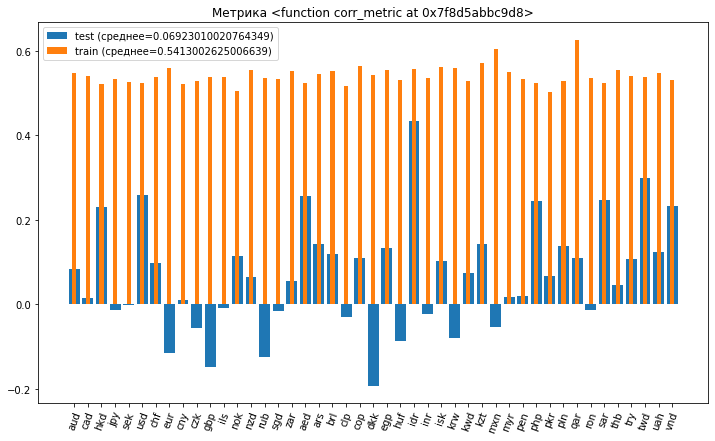

In [0]:
def my_metric(metric_func):
    train_ = [metric_func(y_train[:,k],preds_train[:,k]) for k in range(y.shape[1])]
    test_ = [metric_func(y_test[:,k],preds_test[:,k]) for k in range(y.shape[1])]

    plt.figure(figsize=(12,7))
    plt.bar(cur_names,test_,label="test (среднее={})".format(np.mean(test_)))
    plt.bar(cur_names,train_,width=0.3,label="train (среднее={})".format(np.mean(train_)))
    plt.xticks(rotation=70)
    plt.legend()
    plt.title("Метрика {}".format(metric_func))
    plt.show()

my_metric(mean_absolute_error)
my_metric(mean_squared_error)
my_metric(r2_score)
def corr_metric(x,y): return np.corrcoef(x,y)[0,1]
my_metric(corr_metric)

На простой линейной регрессии слабые значения. Пока "на лицо" переобучение. В тесте результаты значительно слабее чем в обучении.